## Example: Multi-Objective Multi-Fidelity Hyperparameter Optimization

This notebook provides an example for AutoGluon's multi-objective HPO capabilities. Using the MNIST toy problem we show how to use the MOHyperbandScheduler to search for neural network hyperparameters which lead to networks with accurate and fast predictions.

The overall handling is very similar to the standard HyperbandScheduler. The constructor signature differs in two attributes:

1. **objectives**: This attribute is used to specify the objectives of interests. It expects a dictionary. The dictionary values  are used to indicate if a particular objective is meant to be maximized ("MAX") or minimized ("MIN"). 
2. **scalarization_options**: An additional dictionary can be provided to specify a scalarization technique and its parameters. By default "Random Weights" with 100 weight vectors is used.

In [1]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
import autogluon.core as ag

### Get MNIST data

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]
classes = np.unique(y)

### Define a training function that returns multiple objectives

In [3]:
# Specify search space for MLPs
@ag.args(
    n_layers=ag.space.Int(1, 4),
    layer_1=ag.space.Int(2, 32),
    layer_2=ag.space.Int(2, 32),
    layer_3=ag.space.Int(2, 32),
    layer_4=ag.space.Int(2, 32),
    alpha=ag.space.Real(1e-6, 1e-1, log=True),
    learning_rate_init=ag.space.Real(1e-6, 1e-2, log=True),
    beta_1=ag.space.Real(0.001, 0.99, log=True),
    beta_2=ag.space.Real(0.001, 0.99, log=True),
    tol=ag.space.Real(1e-5, 1e-2, log=True),
    epochs=50)
def train_fn(args, reporter):
    
    # Initialize model with args
    hidden = [args.layer_1, args.layer_2, args.layer_3, args.layer_4][:args.n_layers]
    mlp = MLPClassifier(hidden_layer_sizes=hidden,
                        alpha=args.alpha,
                        learning_rate_init=args.learning_rate_init,
                        beta_1=args.beta_1,
                        beta_2=args.beta_2,
                        tol=args.tol,
                        verbose=False)

    # Train model iteratively
    for e in range(args.epochs):
        mlp.partial_fit(X_train, y_train, classes)
        train_score = mlp.score(X_train, y_train)
        test_score = mlp.score(X_test, y_test)
        start = time.time()
        mlp.predict(X_train)
        prediction_time = time.time() - start
        
        # Ensure to return all quantities of interest
        reporter(epoch=e+1, train_score=train_score, test_score=test_score, prediction_time=prediction_time)

### Run hyperparameter search

In [4]:
# Objectives are specified as dictionary with indication if they should be 
# maximized or minimized
objectives = {
    "test_score": "MAX",
    "prediction_time": "MIN"
}

# The scalarization algorithm to be used and its parameters are provided as
# a dictionary. There are two different scalarization algorithms available.
random_weights_options = {
    "algorithm": "random_weights",
    "num_weights": 100
}

parego_options = {
    "algorithm": "parego",
    "num_weights": 100,
    "rho": 0.05,
}

scheduler = ag.scheduler.MOHyperbandScheduler(
    train_fn,
    resource={'num_cpus': 4, 'num_gpus': 0},
    num_trials=10, # 40,
    objectives=objectives,
    scalarization_options=random_weights_options,
    time_attr='epoch',
    grace_period=1,
    reduction_factor=3,
    type='stopping',
    max_t=50
)
scheduler.run()
scheduler.join_jobs()

/home/robin/installs/miniconda3/envs/vmbo/lib/python3.6/site-packages/distributed/worker.py:3382: UserWarning: Large object of size 439.19 MB detected in task graph: 
  (<function train_fn at 0x7f2c9993e1e0>, {'args': { ... sReporter}, [])
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


### Retrieve history for every objective

In [5]:
# Collect data about all the points
histories = defaultdict(list)
for task_id, task_res in scheduler.training_history.items():
    for res_dict in task_res:
        for o in objectives:
            histories[o].append(res_dict[o])

In [6]:
# Collect Pareto efficient points
front = scheduler.get_pareto_front()
pareto_score = [e["test_score"] for e in front]
pareto_time = [e["prediction_time"] for e in front]

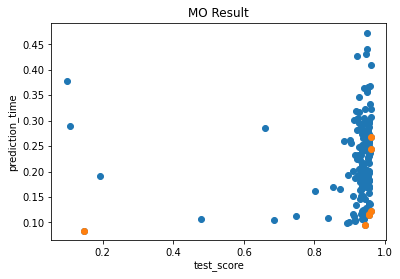

In [7]:
# Visualize findings in scatter plot
plt.xlabel("test_score")
plt.ylabel("prediction_time")
plt.title("MO Result")
plt.scatter(histories["test_score"], histories["prediction_time"])
plt.scatter(pareto_score, pareto_time)
plt.show()

In [8]:
front

[{'task_id-ressource': ('2', 1),
  'test_score': 0.1477,
  'prediction_time': 0.08407330513000488},
 {'task_id-ressource': ('3', 8),
  'test_score': 0.9602,
  'prediction_time': 0.26778221130371094},
 {'task_id-ressource': ('3', 13),
  'test_score': 0.9557,
  'prediction_time': 0.11610841751098633},
 {'task_id-ressource': ('3', 15),
  'test_score': 0.9551,
  'prediction_time': 0.11386990547180176},
 {'task_id-ressource': ('3', 16),
  'test_score': 0.9592,
  'prediction_time': 0.12224078178405762},
 {'task_id-ressource': ('3', 20),
  'test_score': 0.9596,
  'prediction_time': 0.24402642250061035},
 {'task_id-ressource': ('4', 8),
  'test_score': 0.9447,
  'prediction_time': 0.09518671035766602}]